# imports

In [1]:
import pandas as pd
import requests
from scipy import stats
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# get data

In [2]:
API_KEY = "3856b633126e4a27b2e45516c9290395"
URL = f"https://api.covidactnow.org/v2/states.timeseries.csv?apiKey={API_KEY}"
PATH = "data/states_series.csv"

r = requests.get(URL)

with open(PATH, 'w') as f:
    f.write(r.text)

# import data

In [3]:
data_all = pd.read_csv(PATH)

# process data

In [4]:
# get only from Colorado
state = 'CO'
data_all = data_all[data_all['state'] == state]
# get dates in range 01/03/2020 to 26/09/2021
date_start = '2020-03-01'
date_stop = '2021-09-26'
data = data_all[(data_all['date']>=date_start) & (data_all['date']<=date_stop)]
# conseguir data test: 27/09/2021 to 04/10/2021
date_start_test = '2021-09-25'
date_stop_test = '2021-10-04'
data_test = data_all[(data_all['date']>=date_start_test) & (data_all['date']<=date_stop_test)]
data
data.columns

Index(['date', 'country', 'state', 'county', 'fips', 'lat', 'long',
       'locationId', 'actuals.cases', 'actuals.deaths',
       'actuals.positiveTests', 'actuals.negativeTests',
       'actuals.contactTracers', 'actuals.hospitalBeds.capacity',
       'actuals.hospitalBeds.currentUsageTotal',
       'actuals.hospitalBeds.currentUsageCovid', 'unused1',
       'actuals.icuBeds.capacity', 'actuals.icuBeds.currentUsageTotal',
       'actuals.icuBeds.currentUsageCovid', 'unused2', 'actuals.newCases',
       'actuals.vaccinesDistributed', 'actuals.vaccinationsInitiated',
       'actuals.vaccinationsCompleted', 'metrics.testPositivityRatio',
       'metrics.testPositivityRatioDetails', 'metrics.caseDensity',
       'metrics.contactTracerCapacityRatio', 'metrics.infectionRate',
       'metrics.infectionRateCI90', 'unused3', 'unused4',
       'metrics.icuCapacityRatio', 'riskLevels.overall',
       'metrics.vaccinationsInitiatedRatio',
       'metrics.vaccinationsCompletedRatio', 'actuals.new

# plot data

<AxesSubplot:>

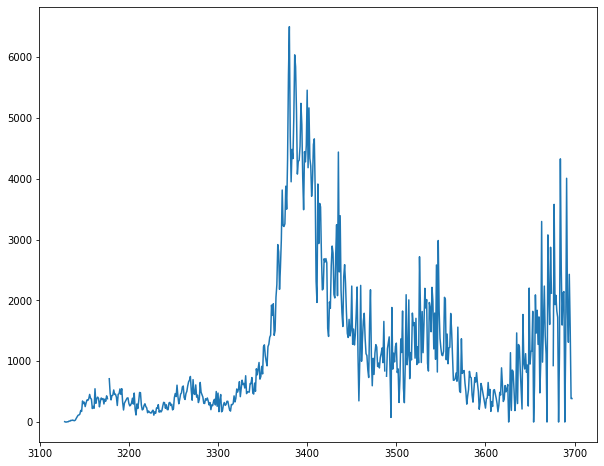

In [5]:
data['actuals.newCases'].plot(x='date', figsize=(10, 8), legend=False)

<AxesSubplot:ylabel='Frequency'>

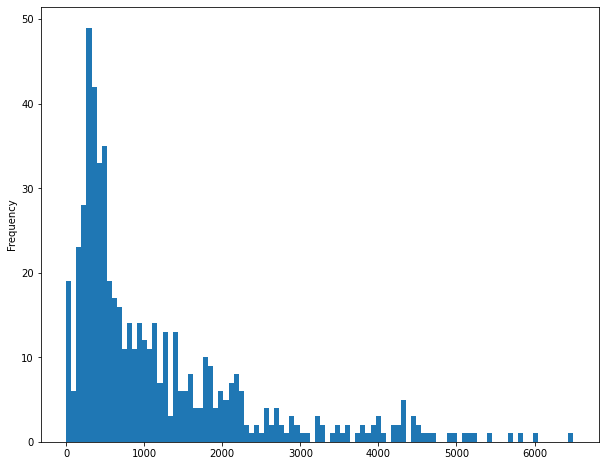

In [6]:
data['actuals.newCases'].plot.hist(bins=100, figsize=(10, 8))

# prepare data

In [7]:
keys = [
    'actuals.newCases',
    'actuals.cases',
    'actuals.newDeaths',
    'actuals.deaths',
    'actuals.positiveTests',
    'actuals.negativeTests',
    'actuals.vaccinesDistributed',
    'actuals.vaccinationsInitiated',
    'actuals.vaccinationsCompleted',
    'metrics.testPositivityRatio',
    'metrics.infectionRate',
#     'riskLevels.caseDensity', 
#     'cdcTransmissionLevel'
]
# get certain cols
data = data[keys]
data_test = data_test[keys]
# avg last n days
n_days = 7
data = data.rolling(n_days).sum()/n_days
# replace nans for 0s
data = data.fillna(0)
data_test = data_test.fillna(0)
# normalize
data_mean = data.mean()
data_std = data.std()
data_std['actuals.newCases'] = data_std['actuals.newCases']*0.05
data_norm = (data-data_mean)/data_std

data_columns = data_norm.columns
torch_data = torch.tensor(data_norm.values)

In [8]:
data

,actuals.newCases,actuals.cases,actuals.newDeaths,actuals.deaths,actuals.positiveTests,actuals.negativeTests,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,metrics.testPositivityRatio,metrics.infectionRate
3123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
3124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
3125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
3126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
3127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
3693,1815.714286,654448.857143,14.714286,7569.571429,656507.142857,9.167702e+06,8.070285e+06,3.735696e+06,3.371417e+06,0.069857,0.982857
3694,1859.285714,656308.142857,15.857143,7585.428571,658448.428571,9.194095e+06,8.075205e+06,3.739606e+06,3.376068e+06,0.069714,0.984286
3695,1775.571429,658083.714286,14.428571,7599.857143,660413.142857,9.221222e+06,8.078816e+06,3.743579e+06,3.380832e+06,0.069571,0.987143
3696,1830.714286,659914.428571,14.571429,7614.428571,662321.857143,9.247610e+06,8.082315e+06,3.747453e+06,3.385506e+06,0.069286,0.991429


In [9]:
INPUT_DIM = len(keys)
N = torch_data.shape[0] - 1
X = torch.zeros(N, INPUT_DIM)
Y = torch.zeros(N, INPUT_DIM)

for i in range(N):
    X[i,:] = torch_data[i,:]
    Y[i,:] = torch_data[i+1,:]

# for i in range(N):
#     X[i,:,:] = torch_data[i:i+MEM_SHIFTS,:]
#     Y[i,:] = torch_data[i+MEM_SHIFTS,:]

# model

In [10]:
class LSTMcovid(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMcovid, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.hidden2vals = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, sequence):
        lstm_out, hidden = self.lstm(sequence)
        vals = self.hidden2vals(lstm_out)
        return vals
    
    def suit4model(self, tsr):
        return tsr.unsqueeze(1).float()

In [11]:
HIDDEN_DIM = 20
model = LSTMcovid(INPUT_DIM, HIDDEN_DIM)

# run model

In [12]:
with torch.no_grad():
    X2 = model.suit4model(X)
    Y_preds = model(X2)
    print(Y_preds, Y_preds.shape)
    print(Y, Y.shape)

tensor([[[-0.0367,  0.1737, -0.2609,  ..., -0.1031,  0.2629, -0.0848]],

        [[-0.0454,  0.2351, -0.2937,  ..., -0.0501,  0.3299, -0.1043]],

        [[-0.0530,  0.2596, -0.2985,  ..., -0.0275,  0.3518, -0.1103]],

        ...,

        [[ 0.1203, -0.2525, -0.2456,  ..., -0.5677, -0.0593,  0.1304]],

        [[ 0.1124, -0.2569, -0.2344,  ..., -0.5561, -0.0455,  0.1264]],

        [[ 0.1171, -0.2525, -0.2396,  ..., -0.5605, -0.0518,  0.1310]]]) torch.Size([574, 1, 11])
tensor([[-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        ...,
        [ 11.8536,   1.6357,   0.1450,  ...,   2.1883,   0.2656,  -0.1511],
        [ 12.8338,   1.6435,   0.1551,  ...,   2.1922,   0.2564,  -0.1319],
        [ 10.4621,   1.6508,   0.1248,  ...,   2.1961,   0.2472,  -0.1127]]) torch.Size([574, 11])


# train model

In [13]:
EPOCHS = 20

loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(EPOCHS):
    print(f'epoch: {epoch}')
    model.zero_grad()

    suited_X = model.suit4model(X)
    Y_preds = model(suited_X).squeeze()
    print(Y_preds, Y_preds.shape)
    print(Y, Y.shape)
#     Y = Y.long()
        
    
    loss = loss_function(Y_preds, Y)
    loss.backward()
    optimizer.step()


epoch: 0
tensor([[-0.0367,  0.1737, -0.2609,  ..., -0.1031,  0.2629, -0.0848],
        [-0.0454,  0.2351, -0.2937,  ..., -0.0501,  0.3299, -0.1043],
        [-0.0530,  0.2596, -0.2985,  ..., -0.0275,  0.3518, -0.1103],
        ...,
        [ 0.1203, -0.2525, -0.2456,  ..., -0.5677, -0.0593,  0.1304],
        [ 0.1124, -0.2569, -0.2344,  ..., -0.5561, -0.0455,  0.1264],
        [ 0.1171, -0.2525, -0.2396,  ..., -0.5605, -0.0518,  0.1310]],
       grad_fn=<SqueezeBackward0>) torch.Size([574, 11])
tensor([[-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        ...,
        [ 11.8536,   1.6357,   0.1450,  ...,   2.1883,   0.2656,  -0.1511],
        [ 12.8338,   1.6435,   0.1551,  ...,   2.1922,   0.2564,  -0.1319],
        [ 10.4621,   1.6508,   0.1248,  ...,   2.1961,   0.2472,  -0.1127]]) torch.Size([574, 11])
epoch: 1

epoch: 8
tensor([[-3.2177e+00,  4.3539e-02, -2.5185e-01,  ..., -8.8391e-02,
          1.8110e-01, -7.9067e-02],
        [-4.3231e+00,  7.9291e-02, -3.2953e-01,  ..., -3.9256e-02,
          2.5951e-01, -1.1772e-01],
        [-4.6592e+00,  9.4611e-02, -3.5252e-01,  ..., -3.0421e-02,
          2.8820e-01, -1.2581e-01],
        ...,
        [ 5.8740e+00,  2.7905e-02, -1.9992e-01,  ..., -1.9077e-01,
          3.6015e-01, -1.8225e-02],
        [ 5.7170e+00,  3.4464e-02, -1.9953e-01,  ..., -1.7709e-01,
          3.3895e-01, -2.5757e-03],
        [ 5.8027e+00,  3.2094e-02, -2.0010e-01,  ..., -1.8237e-01,
          3.5179e-01, -1.1517e-02]], grad_fn=<SqueezeBackward0>) torch.Size([574, 11])
tensor([[-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        ...,
        [ 11.8536,   1.6357,   0.1450,  ...,   2.1883,   0.2656,  -0

epoch: 16
tensor([[-5.3761e+00, -9.2213e-02, -2.6737e-01,  ..., -4.0238e-02,
          4.1357e-02, -9.4504e-02],
        [-7.1171e+00, -1.0875e-01, -3.3991e-01,  ..., -7.7345e-03,
          4.1857e-02, -1.4905e-01],
        [-7.5389e+00, -1.1515e-01, -3.5459e-01,  ..., -5.4592e-03,
          3.5891e-02, -1.6848e-01],
        ...,
        [ 1.1342e+01,  1.8572e-01,  1.3691e-01,  ...,  3.9507e-02,
          3.0093e-01, -3.3475e-01],
        [ 1.1056e+01,  1.7974e-01,  1.4527e-01,  ...,  4.3794e-02,
          2.8850e-01, -3.4094e-01],
        [ 1.1190e+01,  1.8190e-01,  1.4423e-01,  ...,  4.4213e-02,
          2.9414e-01, -3.3941e-01]], grad_fn=<SqueezeBackward0>) torch.Size([574, 11])
tensor([[-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        ...,
        [ 11.8536,   1.6357,   0.1450,  ...,   2.1883,   0.2656,  -

In [14]:
with torch.no_grad():
    X2 = model.suit4model(X)
    Y_preds = model(X2)
    print(Y_preds, Y_preds.shape)
    print(Y, Y.shape)

tensor([[[-6.7470, -0.2612, -0.1987,  ..., -0.1812, -0.0357, -0.0885]],

        [[-8.9114, -0.3286, -0.2443,  ..., -0.1901, -0.0586, -0.1429]],

        [[-9.3594, -0.3401, -0.2531,  ..., -0.1924, -0.0669, -0.1553]],

        ...,

        [[13.5867, -0.0408,  0.3473,  ..., -0.1644,  0.5045, -0.0730]],

        [[13.2106, -0.0548,  0.3470,  ..., -0.1558,  0.4978, -0.0691]],

        [[13.4199, -0.0479,  0.3476,  ..., -0.1603,  0.5001, -0.0708]]]) torch.Size([574, 1, 11])
tensor([[-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        [-19.7064,  -1.1881,  -0.8748,  ...,  -0.6257,  -1.9692,  -4.5704],
        ...,
        [ 11.8536,   1.6357,   0.1450,  ...,   2.1883,   0.2656,  -0.1511],
        [ 12.8338,   1.6435,   0.1551,  ...,   2.1922,   0.2564,  -0.1319],
        [ 10.4621,   1.6508,   0.1248,  ...,   2.1961,   0.2472,  -0.1127]]) torch.Size([574, 11])


In [15]:
Y_preds_numpy = Y_preds.squeeze()
Y_preds_numpy = Y_preds_numpy.numpy()
output = pd.DataFrame(Y_preds_numpy, columns=data_columns)
output
type(output)
denorm_output = output*data_std + data_mean

,preds,real
0,729.099734,0.000000
1,607.328678,0.000000
2,582.122509,0.000000
3,576.821033,0.000000
4,575.521753,0.000000
...,...,...
570,1864.368962,1815.714286
571,1873.075146,1859.285714
572,1851.912111,1775.571429
573,1863.692173,1830.714286


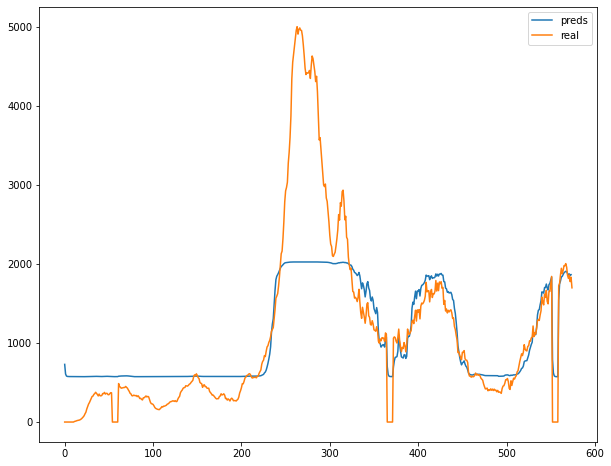

In [16]:
compare_df = pd.DataFrame([denorm_output['actuals.newCases'], data['actuals.newCases'].reset_index(drop=True)]).transpose()
compare_df.columns = ['preds', 'real']
compare_df.plot(figsize=(10, 8))
compare_df

# Performance eval
## train

In [17]:
preds = denorm_output['actuals.newCases'].to_numpy()
reals = data['actuals.newCases'].to_numpy()[1:]

In [18]:
RMSE_train = np.sqrt(np.sum(np.square(preds - reals))/preds.shape)
MAE_train = np.sum(np.abs(preds - reals))/preds.shape

In [19]:
print('RMSE_train', RMSE_train, 'MAE_train', MAE_train)

RMSE_train [699.98135109] MAE_train [388.54697421]


## test

In [20]:
days = data_test.shape[0]
prev_days = data.shape[0]-1

X = X[-prev_days:]
print(X.shape)

for day in range(days):
    with torch.no_grad():
        X2 = model.suit4model(X)
        Y_preds = model(X2).squeeze()
        X[:prev_days-1] = X[1:prev_days].clone()
        X[prev_days-1] = Y_preds[-1]

Y_preds = X[-days:]

torch.Size([574, 11])


In [21]:
Y_preds_numpy = Y_preds.squeeze()
Y_preds_numpy = Y_preds_numpy.numpy()
output = pd.DataFrame(Y_preds_numpy, columns=data_columns)
output
type(output)
denorm_output = output*data_std + data_mean

In [22]:
denorm_output

,actuals.newCases,actuals.cases,actuals.newDeaths,actuals.deaths,actuals.positiveTests,actuals.negativeTests,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,metrics.testPositivityRatio,metrics.infectionRate
0,1863.692173,265740.017793,17.295547,3974.856511,309499.440416,3.388547e+06,1.900081e+06,9.280579e+05,559208.842867,0.076874,1.005082
1,1929.027612,284074.010572,17.063854,4054.937497,312730.501597,3.354863e+06,1.870199e+06,1.031151e+06,562592.523891,0.078147,1.002514
2,1949.646383,289207.892350,17.081257,4043.539837,314226.816544,3.368469e+06,1.854749e+06,1.063753e+06,553787.355404,0.078611,0.997119
3,1957.728358,290942.431397,17.128987,4040.043724,315200.782264,3.364177e+06,1.856189e+06,1.079264e+06,552378.929462,0.078859,0.994423
4,1961.473177,291490.042895,17.174260,4038.704961,315751.874376,3.357635e+06,1.861281e+06,1.087439e+06,552511.748154,0.079012,0.992915
5,1963.470654,291620.474169,17.210285,4038.362456,316063.336700,3.352085e+06,1.866289e+06,1.092049e+06,553088.602698,0.079113,0.992012
6,1964.642721,291597.189692,17.237943,4038.458280,316242.477415,3.347825e+06,1.870483e+06,1.094795e+06,553743.941828,0.079182,0.991441
7,1965.376865,291519.751874,17.259137,4038.728243,316348.114742,3.344607e+06,1.873852e+06,1.096505e+06,554355.974796,0.079232,0.991062
8,1965.859964,291428.497037,17.275498,4039.047770,316412.213419,3.342159e+06,1.876530e+06,1.097616e+06,554888.466930,0.079268,0.990802
9,1966.191330,291340.002131,17.288252,4039.359511,316452.377318,3.340276e+06,1.878657e+06,1.098366e+06,555336.674067,0.079295,0.990616


In [23]:
data_test

,actuals.newCases,actuals.cases,actuals.newDeaths,actuals.deaths,actuals.positiveTests,actuals.negativeTests,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,metrics.testPositivityRatio,metrics.infectionRate
3696,386.0,664396.0,1.0,7649.0,668384.0,9333946.0,8109865.0,3759587.0,3399977.0,0.067,1.01
3697,386.0,664782.0,13.0,7662.0,669566.0,9347759.0,8109725.0,3764748.0,3405927.0,0.068,1.01
3698,3853.0,668635.0,21.0,7683.0,671260.0,9364745.0,8109725.0,3767056.0,3408864.0,0.068,1.02
3699,2297.0,670932.0,20.0,7703.0,673317.0,9391411.0,8110245.0,3769431.0,3411538.0,0.069,1.03
3700,1384.0,672316.0,14.0,7717.0,676415.0,9426207.0,8127615.0,3773179.0,3415476.0,0.073,1.03
3701,2531.0,674847.0,14.0,7731.0,678741.0,9456574.0,8145395.0,3777400.0,3419720.0,0.074,1.04
3702,2296.0,677143.0,41.0,7772.0,681087.0,9486980.0,8216005.0,3780734.0,3423369.0,0.077,1.05
3703,451.0,677594.0,4.0,7776.0,683134.0,9513288.0,8230095.0,3784978.0,3428116.0,0.076,1.05
3704,416.0,678010.0,6.0,7782.0,684520.0,9528864.0,8227015.0,3792361.0,3437414.0,0.076,1.06
3705,3902.0,681912.0,23.0,7805.0,686303.0,9544931.0,8226595.0,3794362.0,3439988.0,0.077,1.06


<AxesSubplot:>

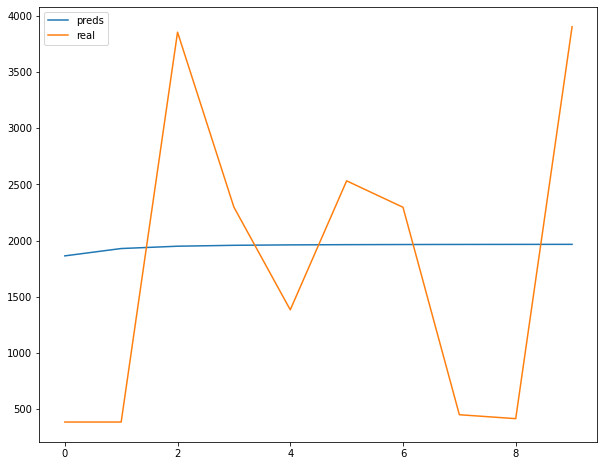

In [24]:
compare_df = pd.DataFrame([denorm_output['actuals.newCases'], data_test['actuals.newCases'].reset_index(drop=True)]).transpose()
compare_df.columns = ['preds', 'real']
compare_df.plot(figsize=(10, 8))

In [25]:
preds = denorm_output['actuals.newCases'].to_numpy()
reals = data_test['actuals.newCases'].to_numpy()

In [26]:
RMSE_train = np.sqrt(np.sum(np.square(preds - reals))/preds.shape)
MAE_train = np.sum(np.abs(preds - reals))/preds.shape

In [27]:
print('RMSE_train', RMSE_train, 'MAE_train', MAE_train)

RMSE_train [1323.27206164] MAE_train [1173.97503466]
